# **<center> Introduction to Python for Practical Problems </center>**
# **<center> New Economic School, MAE 2025 </center>**
## **<center> Home Assignment 5 </center>**

## Задание

Используя датасет `UCI_Credit_Card`, предскажите вероятности дефолта людей, опираясь на существующую информацию.

Описание датасета можно найти [тут](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset).

Целевая переменная (произошел дефолт или нет) лежит в колонке **target**.

Пункты выполнения задания:

1. Посмотрите на данные, как-то их изучите и опишите (совсем маленько).
2. Выберите наиболее подходящие фичи для предсказания вероятности дефолта. Не забывайте правильно представлять дамми-переменные!
3. Выберите подходящую модель для предсказания вероятности дефолта (можно выбрать несколько и сравнить их). Пользоваться можно как `statsmodels`, так и `sklearn`.
4. На основе построенных моделе и предсказаний попробуйте улучшить перформанс модели, поработав с данными (добавьте перемноженные фичи, фичи в степени и так далее).
5. Оформите результаты в табличке в $\LaTeX$, используя для этого модуль `stargazer`. Опишите полученный результат (не больше 2 страних в pdf).

На my.nes загрузите архив, состоящий из кода (jupyter notebook) и файла pdf, в котором описаны результаты исследования. Удачи!

In [1]:
import numpy as np
import pandas as pd
import warnings
import time
start_time = time.time()
warnings.simplefilter("ignore")

In [2]:
df_debt = pd.read_csv('UCI_Credit_Card.csv')

df_debt.sample(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
5746,5747,120000.0,1,3,1,38,2,2,2,2,...,80853.0,82715.0,84805.0,3000.0,3000.0,3000.0,3300.0,3600.0,2700.0,1
22802,22803,620000.0,2,1,2,38,-1,-1,-1,-1,...,16022.0,2581.0,2867.0,8638.0,620.0,16032.0,2856.0,4197.0,920.0,0
8650,8651,20000.0,1,3,1,44,0,0,0,0,...,19684.0,19697.0,19849.0,1328.0,1302.0,686.0,701.0,855.0,988.0,0


In [3]:
df_debt.shape

(30000, 25)

# Data description


### Summary statistics


In [4]:
df_debt['MALE'] = (df_debt['SEX'] == 1).astype(int) #
df_debt.drop(columns=['SEX'], inplace=True)
df_debt_description = df_debt.loc[:,['target', 'LIMIT_BAL', 'MALE', 'MARRIAGE', 'AGE', 'PAY_0', 'BILL_AMT1']].describe()

# Select only specific statistics from the description
desired_statistics = df_debt_description.loc[['mean', 'std', 'min' , '50%', 'max']]

desired_statistics = desired_statistics.round(2)
desired_statistics

,target,LIMIT_BAL,MALE,MARRIAGE,AGE,PAY_0,BILL_AMT1
mean,0.22,167484.32,0.40,1.55,35.49,-0.02,51223.33
std,0.42,129747.66,0.49,0.52,9.22,1.12,73635.86
min,0.00,10000.00,0.00,0.00,21.00,-2.00,-165580.00
50%,0.00,140000.00,0.00,2.00,34.00,0.00,22381.50
max,1.00,1000000.00,1.00,3.00,79.00,8.00,964511.00


average default rate = 0.22

40% of the sample are male

mean age - 35

average bank statement - 51223

average amount of given credit - 167484 (note that is't more then the average bank statement - people have many credits) 

In [5]:
with open('table_1.tex', 'w') as f:
    f.write(desired_statistics.to_latex(float_format="%.2f"))

### Correlation matrix

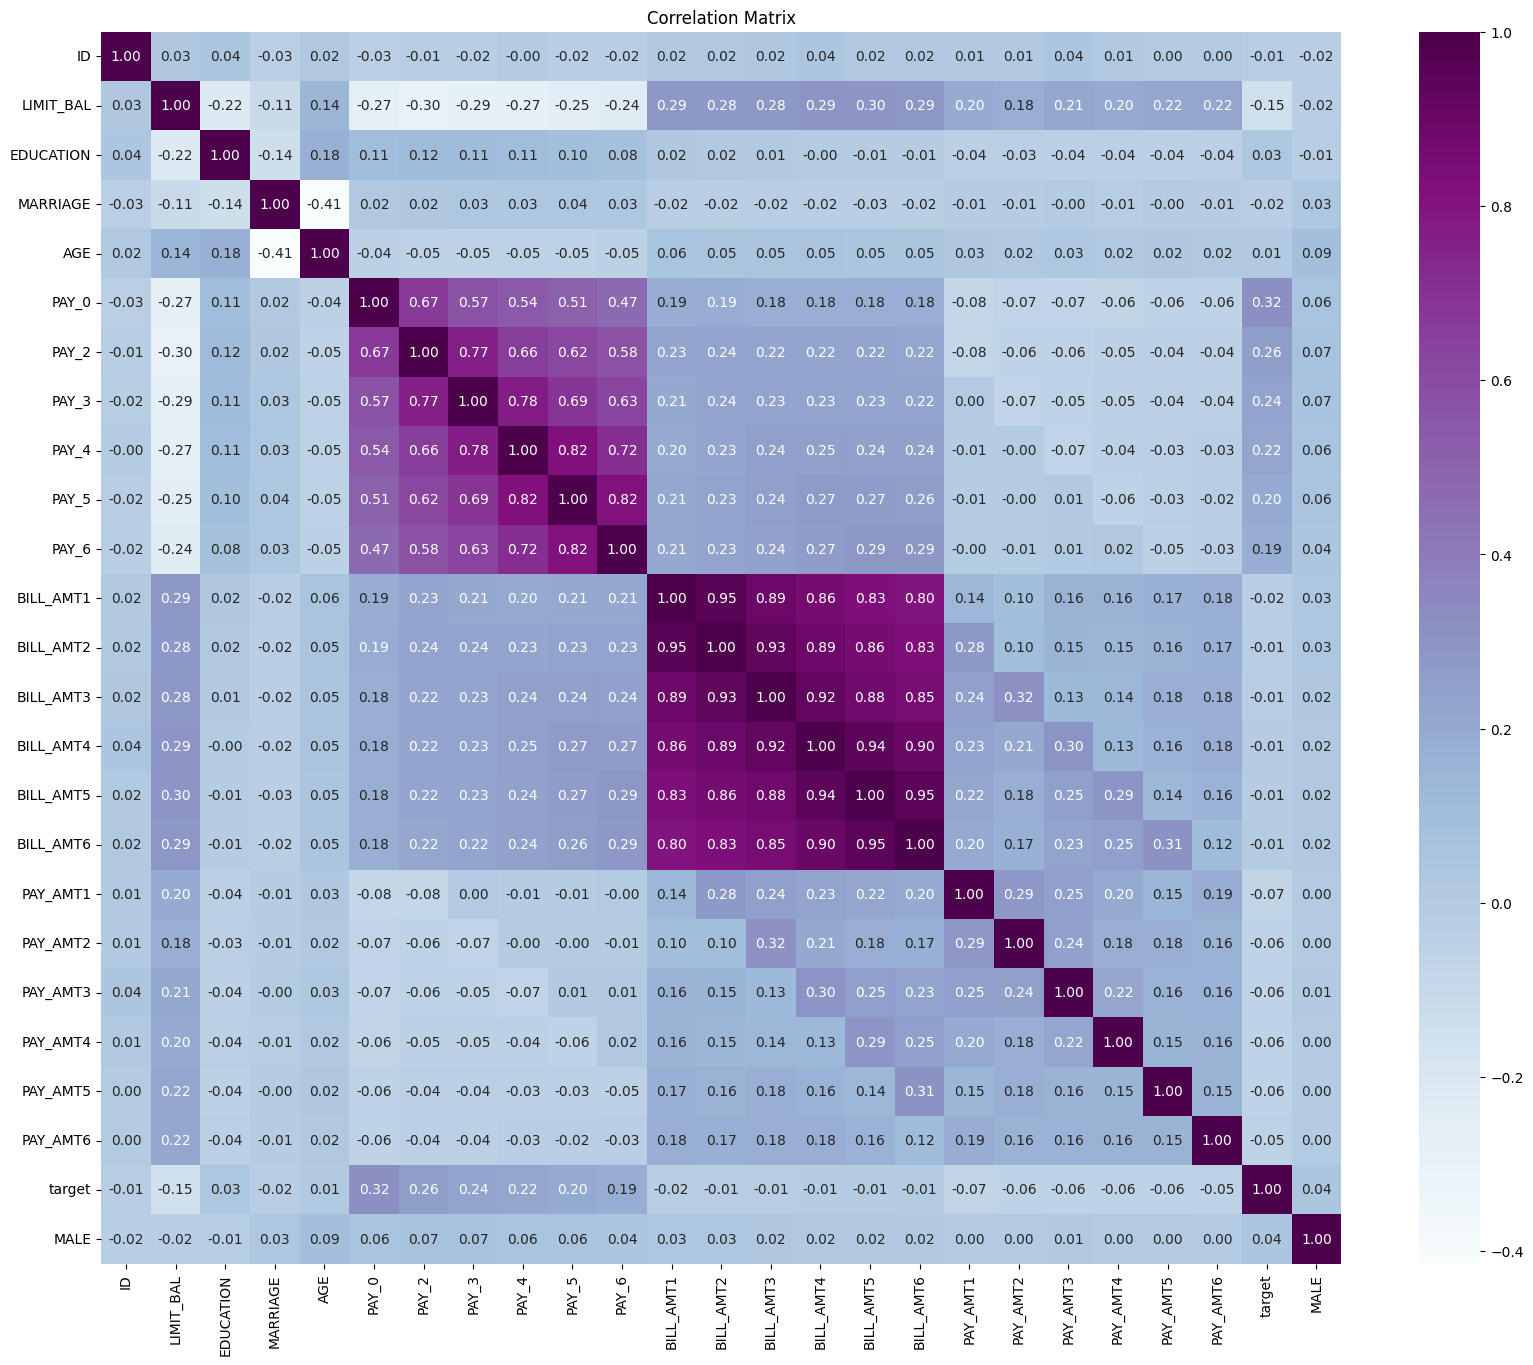

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df_debt.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f")

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

Only expected autocorrelation (between pays and bills) is observed, nothing unexpected.

# Specification choice - for econometric approach

The main idea - use all the variables, but use an average for PAY and BILL, to avoid the noise and potential problems caused by the autocorrelation in these varables.

In [7]:
from statsmodels.api import OLS, add_constant, Logit, Probit
import statsmodels.formula.api as smf

In [8]:
df_debt.columns

Index(['ID', 'LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target',
       'MALE'],
      dtype='object')

### Means calculations

In [9]:
df_debt['PAY_mean'] = df_debt[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)
df_debt['PAY_mean'].sample(2)

3142     0.0
28450   -2.0
Name: PAY_mean, dtype: float64

In [10]:
df_debt['BILL_mean'] = df_debt[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
df_debt['BILL_mean'].sample(2)

9741     36531.166667
25957    20985.666667
Name: BILL_mean, dtype: float64

In [11]:
df_debt['PAY_AMT_mean'] = df_debt[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
df_debt['PAY_AMT_mean'].sample(2)

1322     15370.666667
29424     3072.333333
Name: PAY_AMT_mean, dtype: float64

In [12]:
columns_to_exclude = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                      'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                      'BILL_AMT5', 'BILL_AMT6', 'ID']

debt_clean = df_debt.drop(columns=columns_to_exclude)
debt_clean.columns

Index(['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 'AGE', 'target', 'MALE',
       'PAY_mean', 'BILL_mean', 'PAY_AMT_mean'],
      dtype='object')

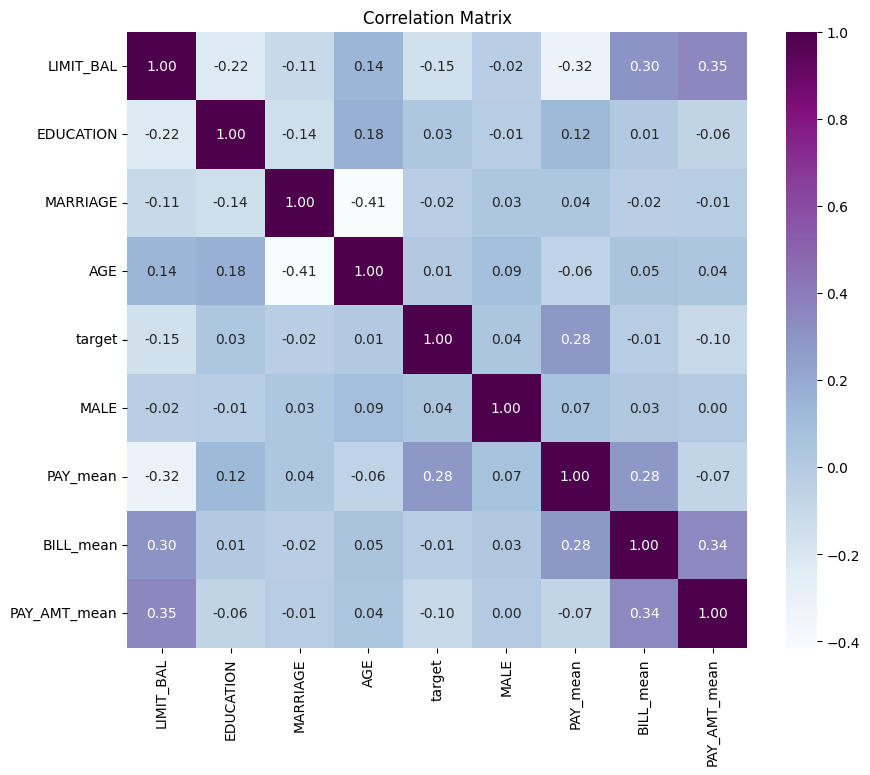

In [13]:
# Compute the correlation matrix
correlation_matrix = debt_clean.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".2f")

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

### Specification formulation

In [14]:
# getting our specification. Dependent variabale - target
spec = [col for col in debt_clean.columns if col != 'target']
spec = 'target ~' + ' + '.join(spec)
spec 

'target ~LIMIT_BAL + EDUCATION + MARRIAGE + AGE + MALE + PAY_mean + BILL_mean + PAY_AMT_mean'

Okay, now let's do the modifications by hand - to introduce the nonlinearity to the model.

AGE - quadratic
LIMIT_BAL - now in %

In [15]:
spec ='target ~ np.log(LIMIT_BAL) + C(MALE, Treatment(reference=0)) + \
        C(EDUCATION, Treatment(reference=2)) + C(MARRIAGE, Treatment(reference=1)) + \
        AGE + AGE**2 + PAY_mean + BILL_mean + PAY_AMT_mean'

In [16]:
# The first unique value is the one that appears first in the dataset
reference_category_sex = debt_clean['MALE'].unique()[0]
print(f"Order of values in the category MALE: {debt_clean['MALE'].unique()}")
print()
print(f"reference_category_sex (index = 0): {reference_category_sex} - female")
print(' ------------------------------------')
# The second unique value is the one that appears second in the dataset
reference_category_educ = debt_clean['EDUCATION'].unique()[2]
print(f"Order of values in the category EDUCATION: {debt_clean['EDUCATION'].unique()}")
print()
print(f"reference_category_educ (index = 2): {reference_category_educ} - high school")
print(' ------------------------------------')
# The second unique value is the one that appears second in the dataset
reference_category_mar = debt_clean['MARRIAGE'].unique()[1]
print(f"Order of values in the category MARRIAGE: {debt_clean['MARRIAGE'].unique()}")
print()
print(f"reference_category_mar (index = 1): {reference_category_mar} - single")

Order of values in the category MALE: [0 1]

reference_category_sex (index = 0): 0 - female
 ------------------------------------
Order of values in the category EDUCATION: [2 1 3 5 4 6 0]

reference_category_educ (index = 2): 3 - high school
 ------------------------------------
Order of values in the category MARRIAGE: [1 2 3 0]

reference_category_mar (index = 1): 2 - single


# Predicting Models

## Econometric approach (statsmodels)

Main idea - to calculate $\beta$ on all available data and hope it will work fine on put-of-sample data.

### OLS

In [17]:
ols_reg = smf.ols(formula=spec, data=debt_clean).fit(cov_type='HC1')
# print(ols_reg.summary2())

### Logit

In [18]:
logit_reg = smf.logit(formula=spec, data=debt_clean).fit()
# print(logit_reg.summary2())

         Current function value: 0.478874
         Iterations: 35


C:\Users\Popov\anaconda3\envs\NES\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Generalized Estimating Equations (GEEs)

In [19]:
import statsmodels.api as sm
gee_model = sm.GEE.from_formula(formula=spec, groups=debt_clean['LIMIT_BAL'], data=debt_clean, family=sm.families.Binomial())
gee_model = gee_model.fit() # clustering by the main independent variablr -  Amount of given credit in NT dollars
# print(gee_model.summary2())

### Results

In [20]:
from stargazer.stargazer import Stargazer

stargazer_res = Stargazer([ols_reg, logit_reg, gee_model])

# Изменим заголовок таблицы
stargazer_res.title('Default Risk of a Credit Card')

# Изменим названия моделей
stargazer_res.custom_columns(['OLS', 'Logit', 'GEE'], [1, 1, 1])

# Изменим число цифр после запятой
stargazer_res.significant_digits(4)

# Изменим порядок отображения регрессоров
stargazer_res.covariate_order(['Intercept',
                               'AGE', 
                               'C(MALE, Treatment(reference=0))[T.1]', 
                               'np.log(LIMIT_BAL)',
                               'PAY_mean', 
                               'BILL_mean', 
                               'PAY_AMT_mean',
                               'C(EDUCATION, Treatment(reference=2))[T.0]',
                               'C(EDUCATION, Treatment(reference=2))[T.1]',
                               'C(EDUCATION, Treatment(reference=2))[T.4]',
                               'C(EDUCATION, Treatment(reference=2))[T.3]',
                               'C(EDUCATION, Treatment(reference=2))[T.5]',
                               'C(EDUCATION, Treatment(reference=2))[T.6]',
                               'C(MARRIAGE, Treatment(reference=1))[T.0]',
                               'C(MARRIAGE, Treatment(reference=1))[T.2]',
                               'C(MARRIAGE, Treatment(reference=1))[T.3]'])

# Изменим имена регрессоров
stargazer_res.rename_covariates({'Intercept': 'Intercept',
                               'AGE': "Age", 
                               'C(MALE, Treatment(reference=0))[T.1]': "Male", 
                               'np.log(LIMIT_BAL)': 'Amount of given credit (%)',
                               'PAY_mean': 'Average payment status', 
                               'BILL_mean': 'Average bill statement', 
                               'PAY_AMT_mean': 'Average amount of previous payments',
                               'C(EDUCATION, Treatment(reference=2))[T.0]': 'University education', # it's the first category by the order 
                               'C(EDUCATION, Treatment(reference=2))[T.1]': "PhD", # of unique values of debt_clean['EDUCATION'].unique()
                               'C(EDUCATION, Treatment(reference=2))[T.3]': "Unknown education",
                               'C(EDUCATION, Treatment(reference=2))[T.4]': "Other education",
                               'C(EDUCATION, Treatment(reference=2))[T.5]': 'Unknown education (1)',
                               'C(EDUCATION, Treatment(reference=2))[T.6]': 'Unknown education (2)',
                               'C(MARRIAGE, Treatment(reference=1))[T.0]': 'Married', # it's the first category by the order 
                               'C(MARRIAGE, Treatment(reference=1))[T.2]': 'Other status',  # of unique values of debt_clean['MARRIAGE'].unique()
                               'C(MARRIAGE, Treatment(reference=1))[T.3]':'Unknown status'})
# Set the name of the dependent variable
stargazer_res.dependent_variable_name('Default Chance')

# # Добавим нотацию к таблице
stargazer_res.add_custom_notes(['Only in-sample predictions.'])
stargazer_res

Note: the magnitude of the effect is taken from the column (1) - OLS (Logit isn't that trivial to interpret). But in most cases, the direction of the effects and their significance coincide.

So, first of all, males are more likely to default (compared to females) by 1.35%.

Secondly, PhD graduates are more likely to default (1.74%), while university graduates are less likely to defauls (12.6%) (compared to high school graduates)

Additionally, the older the person is - the more likely the default is (a year - additional 0.12%).

Marriage also decreases the chance of a default (by 14.5%).

Also, notably, the amount of credit given reduces the chance of the default.

Controls: Average payment status, Average bill statement, Average amount of previous payments.

In [21]:
# to latex
print(stargazer_res.render_latex())

\begin{table}[!htbp] \centering
  \caption{Default Risk of a Credit Card}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable: Default Chance}} \
\cr \cline{2-4}
\\[-1.8ex] & \multicolumn{1}{c}{OLS} & \multicolumn{1}{c}{Logit} & \multicolumn{1}{c}{GEE}  \\
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 Intercept & 0.5242$^{***}$ & 0.3722$^{*}$ & 0.3722$^{}$ \\
& (0.0373) & (0.2249) & (0.3932) \\
 Age & 0.0012$^{***}$ & 0.0057$^{***}$ & 0.0057$^{*}$ \\
& (0.0003) & (0.0018) & (0.0030) \\
 Male & 0.0135$^{***}$ & 0.0942$^{***}$ & 0.0942$^{***}$ \\
& (0.0048) & (0.0303) & (0.0259) \\
 Amount of given credit (%) & -0.0246$^{***}$ & -0.1343$^{***}$ & -0.1343$^{***}$ \\
& (0.0032) & (0.0195) & (0.0400) \\
 Average payment status & 0.1187$^{***}$ & 0.6690$^{***}$ & 0.6690$^{***}$ \\
& (0.0031) & (0.0182) & (0.0471) \\
 Average bill statement & -0.0000$^{***}$ & -0.0000$^{***}$ & -0.0000$^{**}$ \\
& (0.0000) & (0.0000

## Machine learning approach (sklearn)

Main idea - to split the sample into train and test. Fit the model on the train sample and obtain error terms on the test one. Unlike econometric approach, here we do not really care anout the regresssors we include - the more the merrier (get any information we can.

#### Introduction of new featutes

In [22]:
df_debt.sample(2)

,ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target,MALE,PAY_mean,BILL_mean,PAY_AMT_mean
25215,25216,30000.0,1,2,23,0,0,0,0,0,...,1300.0,1300.0,700.0,1000.0,1000.0,1,0,0.000000,16880.333333,1100.000000
18083,18084,250000.0,1,2,29,1,-1,2,2,-2,...,0.0,0.0,0.0,3081.0,0.0,0,1,0.166667,1760.666667,1350.666667


Note that unlike in the econometric approach, here we are not really afraid of multicollinearity - thus, using the original dataset with all the lags.

In [23]:
df_debt.drop(columns=['PAY_mean', 'BILL_mean', 'PAY_AMT_mean'], inplace=True)

In [24]:
# Initialize OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop='if_binary')

# Columns to encode
columns_to_encode = ['EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in columns_to_encode:
    # Fit and transform the column with OneHotEncoder
    encoded = ohe.fit_transform(df_debt[[col]])
    
    # Create column names for the one-hot encoded columns
    encoded_columns = [f'{col}_{category}' for category in ohe.categories_[0][1:]]  # Exclude the first category
    
    # Create a DataFrame from the one-hot encoded values with proper column names
    encoded_df = pd.DataFrame(encoded.toarray()[:, :-1], columns=encoded_columns)
    
    # Concatenate the new DataFrame with the original DataFrame
    df_debt = pd.concat([df_debt, encoded_df], axis=1)
    
    # Drop the initial column
    df_debt.drop(columns=[col], inplace=True)

# Transform 'LIMIT_BAL' column
df_debt['LIMIT_BAL'] = np.log(df_debt['LIMIT_BAL'])

# Create 'AGE_2' column
df_debt['AGE_2'] = df_debt['AGE']**2

In [25]:
df_debt.columns

Index(['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target', 'MALE',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
       'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7',
       'PAY_5_8', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2'

#### Test and train samples

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df_debt.sample(2)

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,AGE_2
21599,21600,10.819778,22,38633.0,36378.0,33533.0,28591.0,28390.0,28739.0,500.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,484
17968,17969,13.017003,34,42713.0,6496.0,9341.0,2857.0,83527.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1156


In [28]:
exog_features = [col for col in df_debt.columns if col != 'target']

X = df_debt[exog_features]
y = df_debt['target']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35,
                                                    random_state=2024, 
                                                    shuffle=True)

### Linear models

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#### OLS

In [30]:
%%time 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_ols = LinearRegression()
# fit on train
model_ols.fit(X_train, y_train)
# predict on test
y_pred_hp_ols = model_ols.predict(X_test)

print(f'Intercept coef : {model_ols.intercept_:.2f}')
print(f'Variables coefs:', *[round(i,2) for i in model_ols.coef_])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_hp_ols, squared=False):.5f}')

# Calculate ROC-AUC
roc_auc_ols = roc_auc_score(y_test, model_ols.predict(X_test))
print(f'ROC-AUC: {roc_auc_ols:.5f}')

Intercept coef : 1.06
Variables coefs: -0.0 -0.05 -0.0 0.0 0.0 -0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.01 -0.03 0.13 0.13 0.12 0.04 0.04 -0.14 0.0 -0.02 -0.31 -0.24 -0.34 -0.17 0.1 0.1 -0.0 -0.1 -0.02 0.07 0.14 0.12 0.15 -0.01 0.16 0.18 0.04 0.34 0.09 0.92 0.16 0.15 0.17 0.04 0.22 0.24 0.2 0.2 -0.25 0.17 1.36 1.35 1.35 1.43 1.42 1.37 1.43 1.08 0.96 0.77 -1.43 -1.46 -1.46 -1.4 -1.39 -1.58 -1.32 -0.5 -0.81 -0.38 -0.39 -0.42 -0.35 -0.26 -0.34 -0.62 -0.25 -0.26 0.0

RMSE: 0.36365
ROC-AUC: 0.76171
CPU times: total: 2.06 s
Wall time: 349 ms


#### Linear Ridge

In [31]:
%%time 
from sklearn.linear_model import Ridge

model_ridge = Ridge()
model_ridge.fit(X_train, y_train)

y_pred_hp_ridge = model_ridge.predict(X_test)

print(f'Intercept coef : {model_ridge.intercept_:.2f}')
print(f'Variables coefs:', *[round(i,2) for i in model_ridge.coef_])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_hp_ridge, squared=False):.5f}')


# Calculate ROC-AUC
roc_auc_ridge = roc_auc_score(y_test, model_ridge.predict(X_test))
print(f'ROC-AUC: {roc_auc_ridge:.5f}')

Intercept coef : 0.95
Variables coefs: -0.0 -0.05 -0.0 0.0 0.0 -0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.01 -0.04 0.12 0.12 0.11 0.02 0.02 -0.13 0.0 -0.02 -0.26 -0.19 -0.29 -0.11 0.16 0.16 0.05 -0.04 0.11 0.07 -0.0 -0.03 0.01 -0.15 0.02 0.04 -0.1 0.09 0.01 0.34 -0.01 -0.02 -0.01 -0.05 0.05 0.07 0.01 -0.02 -0.06 0.04 0.09 0.08 0.08 0.04 0.15 0.12 0.17 -0.1 -0.16 -0.04 -0.06 -0.08 -0.08 -0.02 -0.02 -0.2 -0.05 0.17 0.13 -0.1 -0.1 -0.13 -0.07 0.02 -0.07 -0.23 -0.02 -0.03 0.0

RMSE: 0.36348
ROC-AUC: 0.76196
CPU times: total: 15.6 ms
Wall time: 34.3 ms


#### Linear Lasso

In [32]:
%%time 
from sklearn.linear_model import Lasso

model_lasso = Lasso()
model_lasso.fit(X_train, y_train)

y_pred_hp_lasso = model_lasso.predict(X_test)

print(f'Intercept coef : {model_lasso.intercept_:.2f}')
print(f'Variables coefs:', *[round(i,2) for i in model_lasso.coef_])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_hp_lasso, squared=False):.5f}')


# Calculate ROC-AUC
roc_auc_lasso= roc_auc_score(y_test, model_lasso.predict(X_test))
print(f'ROC-AUC: {roc_auc_lasso:.5f}')

Intercept coef : 0.24
Variables coefs: -0.0 -0.0 -0.0 -0.0 0.0 -0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

RMSE: 0.40516
ROC-AUC: 0.61740
CPU times: total: 1.62 s
Wall time: 678 ms


So, lasso didn't do well - just killed all the variables.

For now, ridge is the best - but OLS isn't really far back.

#### Support Vector Machine (SVM) - regression

Before using this model, we should scale the variable to ensute the convergence of the optimization algorythm.


In [33]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)

In [34]:
from tqdm import tqdm
from sklearn import svm

# Initialize the SVR model
reg_svm = svm.SVR(kernel='rbf') # with linear -smth is wrong

# Fit the model
with tqdm(total=len(X_train_scaled), desc="Training SVR") as pbar:
    reg_svm.fit(X_train_scaled, y_train)
    pbar.update(len(X_train_scaled))

# Predictions on the test set
with tqdm(total=len(X_test_scaled), desc="Predicting SVR") as pbar:
    y_pred_hp_reg_svm = []
    for X in X_test_scaled:
        y_pred_hp_reg_svm.append(reg_svm.predict([X]))
        pbar.update(1)

y_pred_hp_reg_svm = np.array(y_pred_hp_reg_svm)

print(f'RMSE: {mean_squared_error(y_test, y_pred_hp_reg_svm, squared=False):.5f}')

roc_auc_reg_svm = roc_auc_score(y_test, reg_svm.predict(X_test))
print(f'ROC-AUC: {roc_auc_reg_svm:.5f}')

Predicting SVR: 100%|██████████| 10500/10500 [00:09<00:00, 1147.03it/s]


RMSE: 0.37598
ROC-AUC: 0.50000


#### Support Vector Machine (SVM) - classification

In [35]:
%%time
clf_svm = svm.SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train_scaled, y_train)

y_pred_clf_svm = clf_svm.predict_proba(X_test_scaled)[:, 1]

print(f'RMSE: {mean_squared_error(y_test, y_pred_clf_svm, squared=False):.5f}')

roc_auc_clf_svm = roc_auc_score(y_test, y_pred_clf_svm)

print(f'ROC-AUC: {roc_auc_clf_svm:.5f}')

RMSE: 0.36976
ROC-AUC: 0.71976
CPU times: total: 35.9 s
Wall time: 1min 25s


### Non-linear models

#### Logit

In [36]:
model_logreg = LogisticRegression(penalty=None, solver='saga')
model_logreg.fit(X_train, y_train)

# this is usefull not for ROC-AUC -  predict_proba does the job for it
y_pred_logreg = model_logreg.predict(X_test)

roc_auc_logit = roc_auc_score(y_test, model_logreg.predict_proba(X_test)[:,1])

# print(f'Intercept coef : {model_logreg.intercept_[0]:.4f}')
print(f'Variables coefs:', *[round(i,4) for i in model_logreg.coef_[0]])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_logreg, squared=False):.5f}')
print(f'ROC-AUC: {roc_auc_logit:.5f}')

Variables coefs: -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0

RMSE: 0.45857
ROC-AUC: 0.60802


#### Logit Ridgge

In [37]:
model_logreg_ridge_new = LogisticRegression(penalty='l2', solver='saga')
model_logreg_ridge_new.fit(X_train, y_train)

y_pred_logreg_ridge = model_logreg_ridge_new.predict(X_test)

# print(f'Intercept coef : {model_logreg_ridge_new.intercept_[0]:.4f}')
print(f'Variables coefs:', *[round(i,4) for i in model_logreg_ridge_new.coef_[0]])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_logreg_ridge, squared=False):.5f}')
roc_auc_log_ridge = roc_auc_score(y_test, model_logreg_ridge_new.predict_proba(X_test)[:,1])
print(f'ROC-AUC: {roc_auc_log_ridge:.5f}')

Variables coefs: -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0

RMSE: 0.45857
ROC-AUC: 0.60801


#### Logit Lasso 

In [38]:
model_logreg_lasso_new = LogisticRegression(penalty='l1', solver='saga')
model_logreg_lasso_new.fit(X_train, y_train)

y_pred_logreg_lasso = model_logreg_lasso_new.predict(X_test)

# print(f'Intercept coef : {model_logreg_ridge_new.intercept_[0]:.4f}')
print(f'Variables coefs:', *[round(i,4) for i in model_logreg_lasso_new.coef_[0]])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_logreg_lasso, squared=False):.5f}')
roc_auc_log_lasso = roc_auc_score(y_test, model_logreg_lasso_new.predict_proba(X_test)[:,1])
print(f'ROC-AUC: {roc_auc_log_lasso:.5f}')

Variables coefs: -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0

RMSE: 0.45857
ROC-AUC: 0.60801


#### ElasticNet

In [39]:
model_logreg_en_new = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)
model_logreg_en_new.fit(X_train, y_train)

y_pred_logreg_en_new = model_logreg_en_new.predict(X_test)

# print(f'Intercept coef : {model_logreg_en_new.intercept_[0]:.4f}')
print(f'Variables coefs:', *[round(i,4) for i in model_logreg_en_new.coef_[0]])
print()
print(f'RMSE: {mean_squared_error(y_test, y_pred_logreg_en_new, squared=False):.5f}')
roc_auc_elastiv_net = roc_auc_score(y_test, model_logreg_en_new.predict_proba(X_test)[:,1])
print(f'ROC-AUC: {roc_auc_elastiv_net:.5f}')

Variables coefs: -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0

RMSE: 0.45857
ROC-AUC: 0.60803


Enough, let's use some grown-up models) At least a couple of them.

#### Random forest

In [40]:
%%time
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=2022)
model_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = model_rf.predict(X_test)

# Print feature importances if needed
print(f'Feature Importances:', *[round(i, 4) for i in model_rf.feature_importances_])
print()

# Calculate and print ROC-AUC score
roc_auc_rf = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
print(f'RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False):.5f}')
print(f'ROC-AUC: {roc_auc_rf:.5f}')

Feature Importances: 0.0596 0.0482 0.0441 0.0507 0.0463 0.0439 0.044 0.0434 0.043 0.0426 0.0406 0.0389 0.0372 0.037 0.0395 0.0109 0.0 0.0081 0.0088 0.0072 0.0004 0.0007 0.0003 0.0083 0.0079 0.0028 0.0052 0.0163 0.0082 0.0575 0.0047 0.0003 0.0001 0.0 0.0 0.0017 0.0041 0.0064 0.0001 0.0254 0.0025 0.0004 0.0001 0.0 0.0001 0.0024 0.004 0.0045 0.0 0.0183 0.0013 0.0003 0.0001 0.0001 0.0001 0.0021 0.0034 0.0045 0.0 0.0164 0.0012 0.0005 0.0002 0.0 0.0003 0.0022 0.0035 0.0049 0.0118 0.0011 0.0004 0.0002 0.0 0.0004 0.0027 0.0045 0.0043 0.0105 0.0014 0.0003 0.0 0.0002 0.0001 0.0441

RMSE: 0.41725
ROC-AUC: 0.76186
CPU times: total: 1.41 s
Wall time: 6.34 s


#### Gradient boosting (catboost)

In [41]:
from catboost import CatBoostClassifier

# Initialize and train the CatBoost classifier
model_catboost = CatBoostClassifier(iterations=100, random_state=2022, verbose=False)
model_catboost.fit(X_train, y_train)

# Predict on the test set
y_pred_catboost = model_catboost.predict(X_test)

# Calculate and print ROC-AUC score
roc_auc_catboost = roc_auc_score(y_test, model_catboost.predict_proba(X_test)[:, 1])
print(f'RMSE: {mean_squared_error(y_test, y_pred_catboost, squared=False):.5f}')
print(f'ROC-AUC: {roc_auc_catboost:.5f}')

RMSE: 0.41690
ROC-AUC: 0.76347


## ROC-AUC curves

In [42]:
from sklearn.metrics import roc_curve

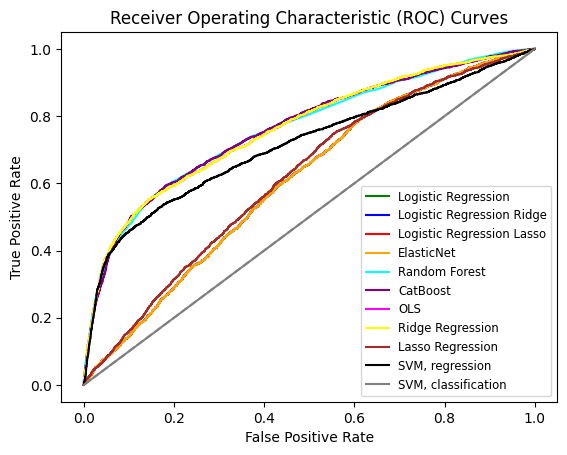

In [43]:
# Calculate ROC curve for Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, model_logreg.predict_proba(X_test)[:,1])

# Plot ROC curve for Logistic Regression
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression', color='green')

# Calculate and plot ROC curve for other models similarly
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, model_logreg_ridge_new.predict_proba(X_test)[:,1])
plt.plot(fpr_ridge, tpr_ridge, label='Logistic Regression Ridge', color='blue')

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, model_logreg_lasso_new.predict_proba(X_test)[:,1])
plt.plot(fpr_lasso, tpr_lasso, label='Logistic Regression Lasso', color='red')

fpr_en, tpr_en, _ = roc_curve(y_test, model_logreg_en_new.predict_proba(X_test)[:,1])
plt.plot(fpr_en, tpr_en, label='ElasticNet', color='orange')

# Calculate ROC curve and ROC-AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])
plt.plot(fpr_rf, tpr_rf, label='Random Forest', color='cyan')

# Calculate ROC curve and ROC-AUC for CatBoost
fpr_catboost, tpr_catboost, _ = roc_curve(y_test, model_catboost.predict_proba(X_test)[:,1])
plt.plot(fpr_catboost, tpr_catboost, label='CatBoost', color='purple')

# Calculate ROC curve and ROC-AUC for OLS
fpr_ols, tpr_ols, _ = roc_curve(y_test, model_ols.predict(X_test))
plt.plot(fpr_ols, tpr_ols, label='OLS', color='magenta')

# Calculate ROC curve and ROC-AUC for Ridge Regression
fpr_ridge_regression, tpr_ridge_regression, _ = roc_curve(y_test, model_ridge.predict(X_test))
plt.plot(fpr_ridge_regression, tpr_ridge_regression, label='Ridge Regression', color='yellow')

# Calculate ROC curve and ROC-AUC for Lasso Regression
fpr_lasso_regression, tpr_lasso_regression, _ = roc_curve(y_test, model_lasso.predict(X_test))
plt.plot(fpr_lasso_regression, tpr_lasso_regression, label='Lasso Regression', color='brown')

# Calculate ROC curve and ROC-AUC for Support Vector Machine (SVM), regression
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_hp_reg_svm)
plt.plot(fpr_svm, tpr_svm, label='SVM, regression', color='black')

# Calculate ROC curve and ROC-AUC for SVM with probability estimates, classification
fpr_clf_svm, tpr_clf_svm, _ = roc_curve(y_test, clf_svm.predict_proba(X_test)[:, 1])
plt.plot(fpr_clf_svm, tpr_clf_svm, label='SVM, classification', color='gray')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(fontsize='small')

# Show plot
plt.savefig('roc_auc_plot.pdf')
plt.show() 

## Comparing table

In [44]:
rmse_scores = {
    'OLS': mean_squared_error(y_test, y_pred_hp_ols, squared=False),
    'Linear Ridge': mean_squared_error(y_test, y_pred_hp_ridge, squared=False),
    'Linear Lasso': mean_squared_error(y_test, y_pred_hp_lasso, squared=False),
    'SVM - regression': mean_squared_error(y_test, y_pred_hp_reg_svm, squared=False),
    'SVM - classification': mean_squared_error(y_test, y_pred_clf_svm, squared=False),
    'Logit':mean_squared_error(y_test, y_pred_logreg, squared=False),
    'Logit Ridge': mean_squared_error(y_test, y_pred_logreg_ridge, squared=False),
    'Logit Lasso': mean_squared_error(y_test, y_pred_logreg_lasso, squared=False),
    'ElasticNet': mean_squared_error(y_test, y_pred_logreg_en_new, squared=False),
    'Random Forest': mean_squared_error(y_test, y_pred_rf, squared=False),
    'Gradient boosting (catboost)': mean_squared_error(y_test, y_pred_catboost, squared=False)

    # Add other models and their RMSE scores here
}

roc_auc_scores = {
    'OLS': roc_auc_ols,
    'Linear Ridge': roc_auc_ridge,
    'Linear Lasso': roc_auc_lasso,
    'SVM - regression': roc_auc_reg_svm,
    'SVM - classification': roc_auc_clf_svm,
    'Logit':roc_auc_logit,
    'Logit Ridge': roc_auc_log_ridge,
    'Logit Lasso': roc_auc_log_lasso,
    'ElasticNet': roc_auc_elastiv_net,
    'Random Forest':roc_auc_rf,
    'Gradient boosting (catboost)':roc_auc_catboost}

# Create DataFrame
df_table = pd.DataFrame({ 'ROC-AUC': roc_auc_scores,'RMSE': rmse_scores})

df_table = df_table.sort_values(by='ROC-AUC', ascending = False)

df_table = df_table.round(decimals=4)

df_table


,ROC-AUC,RMSE
Gradient boosting (catboost),0.7635,0.4169
Linear Ridge,0.7620,0.3635
Random Forest,0.7619,0.4172
OLS,0.7617,0.3636
SVM - classification,0.7198,0.3698
Linear Lasso,0.6174,0.4052
ElasticNet,0.6080,0.4586
Logit,0.6080,0.4586
Logit Ridge,0.6080,0.4586
Logit Lasso,0.6080,0.4586


In [45]:
with open('table_2.tex', 'w') as f:
    f.write(df_table.to_latex(float_format="%.4f"))

In [46]:
# Record the ending time
end_time = time.time()

# Calculate the total time
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60

print(f"Total time taken for notebook execution: {total_time_seconds:.2f} seconds ({total_time_minutes:.2f} minutes)")

Total time taken for notebook execution: 157.22 seconds (2.62 minutes)


So, apart from catboost, Linear Ridge is the best model, judging by roc-auc. Still, it also has the smallest RMSE. Thus, it's the best model according to the both metrics used. Interestingly, it's only a slight improvement from the benchmark model - OLS.